# Negative L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(dim*t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 22705.1640625
iteration 0 loss 12884.86328125


iteration 5000 loss 1.958432912826538


iteration 10000 loss 0.5558777451515198


iteration 15000 loss 0.3017873466014862


iteration 20000 loss 0.2141890525817871


iteration 25000 loss 0.1467972695827484


iteration 30000 loss 0.11840738356113434


iteration 35000 loss 0.08432198315858841


iteration 40000 loss 0.06808630377054214


iteration 45000 loss 0.060761019587516785


iteration 50000 loss 0.05080721154808998


iteration 55000 loss 0.04192904382944107


iteration 60000 loss 0.03809145838022232


iteration 65000 loss 0.07297435402870178


iteration 70000 loss 0.03214876726269722


iteration 75000 loss 0.028013817965984344


iteration 80000 loss 0.02516198344528675


iteration 85000 loss 0.02522287704050541


iteration 90000 loss 0.021357841789722443


iteration 95000 loss 0.026674114167690277


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.01739143393933773


iteration 105000 loss 0.014044348150491714


iteration 110000 loss 0.011684742756187916


iteration 115000 loss 0.009636301547288895


iteration 120000 loss 0.00817142054438591


iteration 125000 loss 0.00701428297907114


iteration 130000 loss 0.006057452876120806


iteration 135000 loss 0.005252724513411522


iteration 140000 loss 0.004563272465020418


iteration 145000 loss 0.00398954376578331


iteration 150000 loss 0.0034730667248368263


iteration 155000 loss 0.0030511037912219763


iteration 160000 loss 0.0026843331288546324


iteration 165000 loss 0.0023640405852347612


iteration 170000 loss 0.0021468487102538347


iteration 175000 loss 0.0018634683219715953


iteration 180000 loss 0.0016470544505864382


iteration 185000 loss 0.0018705785041674972


iteration 190000 loss 0.0012977197766304016


iteration 195000 loss 0.0011605018517002463


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0010408635716885328


iteration 205000 loss 0.0009826470632106066


iteration 210000 loss 0.0008795348694548011


iteration 215000 loss 0.0007874451694078743


iteration 220000 loss 0.00070339220110327


iteration 225000 loss 0.0006313509657047689


iteration 230000 loss 0.0005664929049089551


iteration 235000 loss 0.0005103204166516662


iteration 240000 loss 0.00045803855755366385


iteration 245000 loss 0.0004140311502851546


iteration 250000 loss 0.0003736384678632021


iteration 255000 loss 0.00033669566619209945


iteration 260000 loss 0.0003035108675248921


iteration 265000 loss 0.0002744167868513614


iteration 270000 loss 0.00024803183623589575


iteration 275000 loss 0.0002243229391751811


iteration 280000 loss 0.00020323631179053336


iteration 285000 loss 0.00018431732314638793


iteration 290000 loss 0.00016751048678997904


iteration 295000 loss 0.00015195671585388482


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000138866642373614


iteration 305000 loss 0.00013489513366948813


iteration 310000 loss 0.0001215134616359137


iteration 315000 loss 0.00011074238864239305


iteration 320000 loss 0.00010089685383718461


iteration 325000 loss 9.13172698346898e-05


iteration 330000 loss 8.240420720539987e-05


iteration 335000 loss 7.509114220738411e-05


iteration 340000 loss 6.777306407457218e-05


iteration 345000 loss 6.133077113190666e-05


iteration 350000 loss 5.560881982091814e-05


iteration 355000 loss 5.032492845202796e-05


iteration 360000 loss 4.573407204588875e-05


iteration 365000 loss 4.140398232266307e-05


iteration 370000 loss 3.755125726456754e-05


iteration 375000 loss 3.407104668440297e-05


iteration 380000 loss 3.1002859032014385e-05


iteration 385000 loss 2.8167783966637217e-05


iteration 390000 loss 2.5658613594714552e-05


iteration 395000 loss 2.3356955352937803e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.14035899261944e-05


iteration 405000 loss 2.057111487374641e-05


iteration 410000 loss 1.8079646906699054e-05


iteration 415000 loss 1.6109755961224437e-05


iteration 420000 loss 1.4377817024069373e-05


iteration 425000 loss 1.2840057934226934e-05


iteration 430000 loss 1.1510302101669367e-05


iteration 435000 loss 1.0441665835969616e-05


iteration 440000 loss 9.489112926530652e-06


iteration 445000 loss 8.520798473909963e-06


iteration 450000 loss 7.785493835399393e-06


iteration 455000 loss 7.094441116350936e-06


iteration 460000 loss 6.441378445742885e-06


iteration 465000 loss 5.8864584389084484e-06


iteration 470000 loss 5.408163815445732e-06


iteration 475000 loss 4.968743269273546e-06


iteration 480000 loss 4.539703695627395e-06


iteration 485000 loss 4.16452076024143e-06


iteration 490000 loss 3.8457446862594225e-06


iteration 495000 loss 3.558250000423868e-06


L2 loss -- Plot

loss -15.785987854003906


loss -161.65782165527344


loss -237.82666015625


loss -293.38958740234375


loss -327.0574035644531


loss -341.9483337402344


loss -346.46478271484375


loss -347.3641357421875


loss -347.47381591796875


loss -347.4811706542969


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814147949219


loss -347.4814147949219


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814147949219


loss -347.48138427734375


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


loss -347.4814147949219


loss -347.4814453125


loss -347.4814453125


loss -347.4814453125


final mse:  2.0964219249464122e-09
max, min: 2.4645057 -2.5820453
loss -15.785987854003906


loss -159.83782958984375


loss -239.04736328125


loss -300.1270751953125


loss -341.2932434082031


loss -363.16912841796875


loss -371.8403015136719


loss -374.31036376953125


loss -374.7869873046875


loss -374.8440246582031


loss -374.8477783203125


loss -374.847900390625


loss -374.8479309082031


loss -374.8478698730469


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.8479309082031


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.847900390625


loss -374.8479309082031


final mse:  1.63225777338738e-09
max, min: 2.587315 -2.9169388


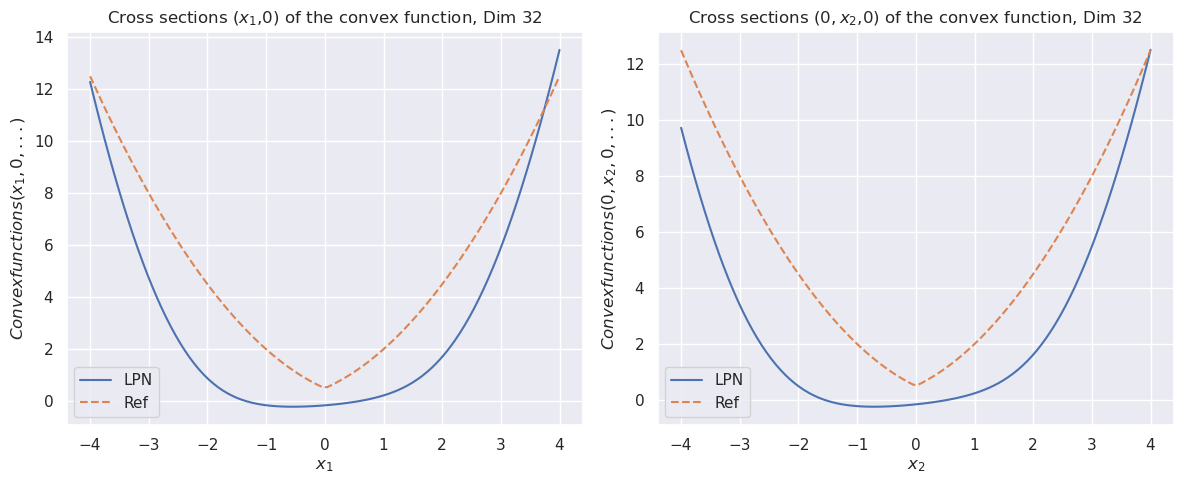

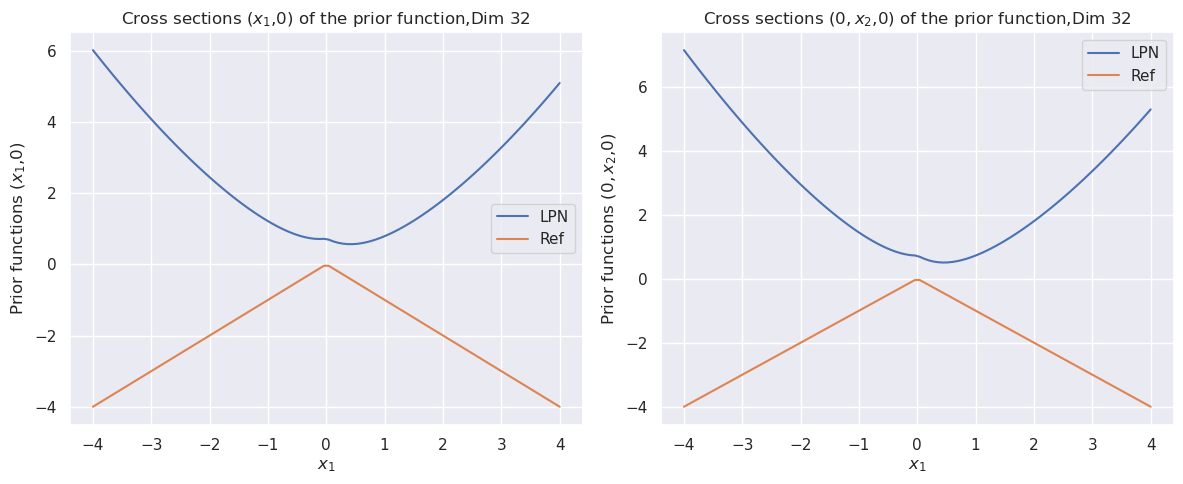

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7979.9248046875
iteration 0 loss 1796.82080078125


iteration 5000 loss 1.8718639612197876


iteration 10000 loss 0.5353540778160095


iteration 15000 loss 0.3340814709663391


iteration 20000 loss 0.24562455713748932


iteration 25000 loss 0.18137520551681519


iteration 30000 loss 0.08708298206329346


iteration 35000 loss 4.197264194488525


iteration 40000 loss 0.0729568600654602


iteration 45000 loss 0.04867493361234665


iteration 50000 loss 0.03300097957253456


iteration 55000 loss 0.02559594064950943


iteration 60000 loss 0.024807045236229897


iteration 65000 loss 0.018279574811458588


iteration 70000 loss 0.0139368437230587


iteration 75000 loss 0.012604753486812115


iteration 80000 loss 0.012427160516381264


iteration 85000 loss 0.009302728809416294


iteration 90000 loss 0.027059728279709816


iteration 95000 loss 3.2663609981536865


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.007753842044621706


iteration 105000 loss 0.004161295481026173


iteration 110000 loss 0.0026045527774840593


iteration 115000 loss 0.001777753233909607


iteration 120000 loss 0.0012706615962088108


iteration 125000 loss 0.0009304875857196748


iteration 130000 loss 0.0006865097675472498


iteration 135000 loss 0.0005183818866498768


iteration 140000 loss 0.00040326040470972657


iteration 145000 loss 0.0021622886415570974


iteration 150000 loss 0.00022368525969795883


iteration 155000 loss 0.00017121352721005678


iteration 160000 loss 0.00013341644080355763


iteration 165000 loss 0.00010974683391395956


iteration 170000 loss 7.794657722115517e-05


iteration 175000 loss 6.088067311793566e-05


iteration 180000 loss 4.869836993748322e-05


iteration 185000 loss 0.0433797761797905


iteration 190000 loss 0.0016805779887363315


iteration 195000 loss 0.002892425050958991


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 3.1682884582551196e-05


iteration 205000 loss 1.5498066204600036e-05


iteration 210000 loss 1.211227663588943e-05


iteration 215000 loss 9.736088941281196e-06


iteration 220000 loss 7.398807611025404e-06


iteration 225000 loss 5.842737664352171e-06


iteration 230000 loss 3.577580355340615e-05


iteration 235000 loss 3.5813143313134788e-06


iteration 240000 loss 2.8287190616538282e-06


iteration 245000 loss 2.2267777239903808e-06


iteration 250000 loss 1.7766574273991864e-06


iteration 255000 loss 1.4210363588063046e-06


iteration 260000 loss 1.0966527952405158e-06


iteration 265000 loss 8.667849442645092e-07


iteration 270000 loss 5.4821535741211846e-05


iteration 275000 loss 5.449675768431916e-07


iteration 280000 loss 4.7209130116243614e-07


iteration 285000 loss 3.4318782127229497e-07


iteration 290000 loss 2.72829822733911e-07


iteration 295000 loss 1.640246750866936e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.7664804374817322e-07


iteration 305000 loss 1.577561619114931e-07


iteration 310000 loss 1.3220497407928633e-07


iteration 315000 loss 1.141817875804918e-07


iteration 320000 loss 1.0105085124223478e-07


iteration 325000 loss 9.164585179632923e-08


iteration 330000 loss 7.99920769622986e-08


iteration 335000 loss 7.240607402536625e-08


iteration 340000 loss 6.367110927385511e-08


iteration 345000 loss 5.594576890644021e-08


iteration 350000 loss 5.0774215054616434e-08


iteration 355000 loss 4.7011411652420065e-08


iteration 360000 loss 4.076978044054158e-08


iteration 365000 loss 6.865656814625254e-06


iteration 370000 loss 3.4516098423864605e-08


iteration 375000 loss 3.197610709548826e-08


iteration 380000 loss 2.991384207007286e-08


iteration 385000 loss 3.649331006272405e-07


iteration 390000 loss 2.5199312858603662e-08


iteration 395000 loss 2.3573930363340878e-08


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 2.174102142760148e-08


iteration 405000 loss 2.1259591420630386e-08


iteration 410000 loss 2.0013263934970382e-08


iteration 415000 loss 1.9121531025234617e-08


iteration 420000 loss 1.8034628013197107e-08


iteration 425000 loss 1.73592962227076e-08


iteration 430000 loss 1.6527451407455374e-08


iteration 435000 loss 1.5798528707478e-08


iteration 440000 loss 1.5140511067102125e-08


iteration 445000 loss 1.4526166935979745e-08


iteration 450000 loss 1.387520143225629e-08


iteration 455000 loss 1.339254040999549e-08


iteration 460000 loss 1.2781651292925744e-08


iteration 465000 loss 1.2248806413595048e-08


iteration 470000 loss 1.1732545601716993e-08


iteration 475000 loss 1.1377141007073988e-08


iteration 480000 loss 1.09118607483083e-08


iteration 485000 loss 1.054234122221942e-08


iteration 490000 loss 1.0193621946541498e-08


iteration 495000 loss 9.928418975846398e-09


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


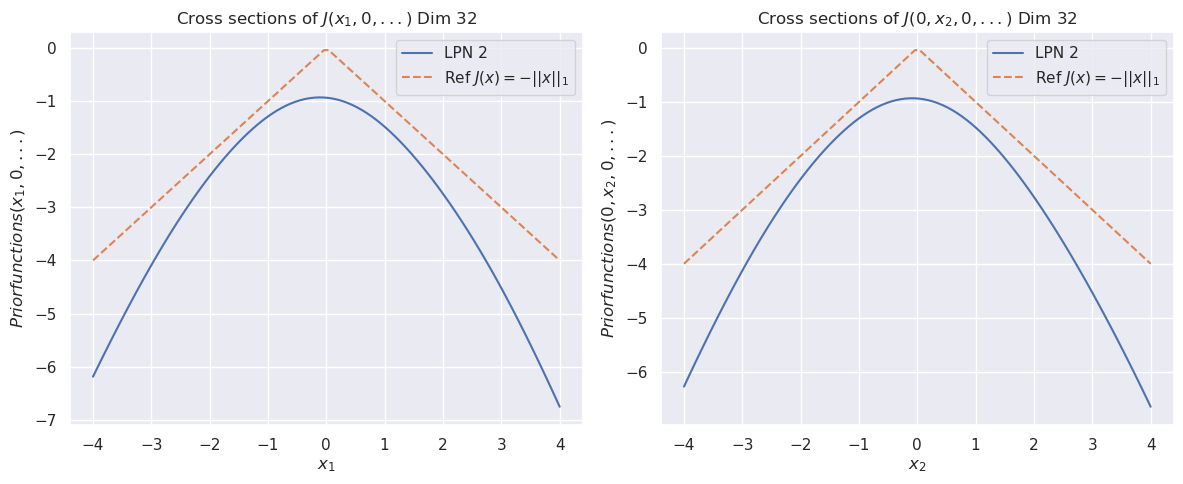

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)